# The IoT Project begins!!

## The AI Carer

A model that can estimate if an elderly person is safe in their home.

## Data Curation Part 1

Today we'll begin our scrubbing and curating our dataset..

The training dataset is here:  
data/training_data.json



In [105]:
# imports

import os
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt
import json
import numpy as np
import random
from collections import Counter, defaultdict
import pickle

In [106]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [107]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [108]:
# One more import - the Item class
# If you get an error that you need to agree to Meta's terms when you run this, then follow the link it provides you and follow their instructions
# You should get approved by Meta within minutes
# Any problems - message me or email me!

from items import Item

In [109]:
%matplotlib inline

In [110]:
# Load in our dataset
# Open and read the JSON file
with open('data/all_data.json', 'r') as file:
    dataset = json.load(file)

# Print the data
print(dataset)

[{'input': [{'timestamp': 1737806400, 'room': 'pillbox', 'nodeId': 1, 'onOff': True}, {'timestamp': 1737806460, 'room': 'bedroom', 'nodeId': 2, 'onOff': True}, {'timestamp': 1737806700, 'room': 'bathroom', 'nodeId': 2, 'onOff': True}, {'timestamp': 1737807000, 'room': 'bathroom', 'nodeId': 3, 'humidity': 6500}, {'timestamp': 1737807300, 'room': 'bathroom', 'nodeId': 2, 'onOff': False}, {'timestamp': 1737807600, 'room': 'kitchen', 'nodeId': 2, 'onOff': True}, {'timestamp': 1737807660, 'room': 'kitchen', 'event': 'fridge_opened'}, {'timestamp': 1737808200, 'room': 'kitchen', 'nodeId': 2, 'onOff': False}, {'timestamp': 1737808500, 'room': 'livingroom', 'nodeId': 2, 'onOff': True}, {'timestamp': 1737808800, 'room': 'livingroom', 'nodeId': 1, 'occupancy': 1}, {'timestamp': 1737810000, 'room': 'livingroom', 'nodeId': 2, 'onOff': False}, {'timestamp': 1737811200, 'room': 'hall', 'nodeId': 1, 'occupancy': 1}, {'timestamp': 1737811800, 'room': 'porch', 'nodeId': 1, 'occupancy': 1}, {'timestamp'

In [111]:
print(f"Number of Situations: {len(dataset):,}")

Number of Situations: 28


In [112]:
# Investigate a particular datapoint
datapoint = dataset[2]


In [113]:
# Investigate

print(datapoint["input"])
print(datapoint["result"])
print(datapoint["reason"])
datapoint

[{'timestamp': 1737979200, 'room': 'pillbox', 'nodeId': 1, 'onOff': True}, {'timestamp': 1737979260, 'room': 'bedroom', 'nodeId': 2, 'onOff': True}, {'timestamp': 1737979500, 'room': 'bathroom', 'nodeId': 2, 'onOff': True}, {'timestamp': 1737979800, 'room': 'bathroom', 'nodeId': 3, 'humidity': 6500}, {'timestamp': 1737980100, 'room': 'bathroom', 'nodeId': 2, 'onOff': False}, {'timestamp': 1737980400, 'room': 'kitchen', 'nodeId': 2, 'onOff': True}, {'timestamp': 1737980460, 'room': 'kitchen', 'event': 'fridge_opened'}, {'timestamp': 1737981000, 'room': 'kitchen', 'nodeId': 2, 'onOff': False}, {'timestamp': 1737981300, 'room': 'livingroom', 'nodeId': 2, 'onOff': True}, {'timestamp': 1737981600, 'room': 'livingroom', 'nodeId': 1, 'occupancy': 1}, {'timestamp': 1737982800, 'room': 'livingroom', 'nodeId': 2, 'onOff': False}, {'timestamp': 1737984000, 'room': 'hall', 'nodeId': 1, 'occupancy': 1}, {'timestamp': 1737984600, 'room': 'porch', 'nodeId': 1, 'occupancy': 1}, {'timestamp': 173798466

{'input': [{'timestamp': 1737979200,
   'room': 'pillbox',
   'nodeId': 1,
   'onOff': True},
  {'timestamp': 1737979260, 'room': 'bedroom', 'nodeId': 2, 'onOff': True},
  {'timestamp': 1737979500, 'room': 'bathroom', 'nodeId': 2, 'onOff': True},
  {'timestamp': 1737979800, 'room': 'bathroom', 'nodeId': 3, 'humidity': 6500},
  {'timestamp': 1737980100, 'room': 'bathroom', 'nodeId': 2, 'onOff': False},
  {'timestamp': 1737980400, 'room': 'kitchen', 'nodeId': 2, 'onOff': True},
  {'timestamp': 1737980460, 'room': 'kitchen', 'event': 'fridge_opened'},
  {'timestamp': 1737981000, 'room': 'kitchen', 'nodeId': 2, 'onOff': False},
  {'timestamp': 1737981300, 'room': 'livingroom', 'nodeId': 2, 'onOff': True},
  {'timestamp': 1737981600, 'room': 'livingroom', 'nodeId': 1, 'occupancy': 1},
  {'timestamp': 1737982800, 'room': 'livingroom', 'nodeId': 2, 'onOff': False},
  {'timestamp': 1737984000, 'room': 'hall', 'nodeId': 1, 'occupancy': 1},
  {'timestamp': 1737984600, 'room': 'porch', 'nodeId': 

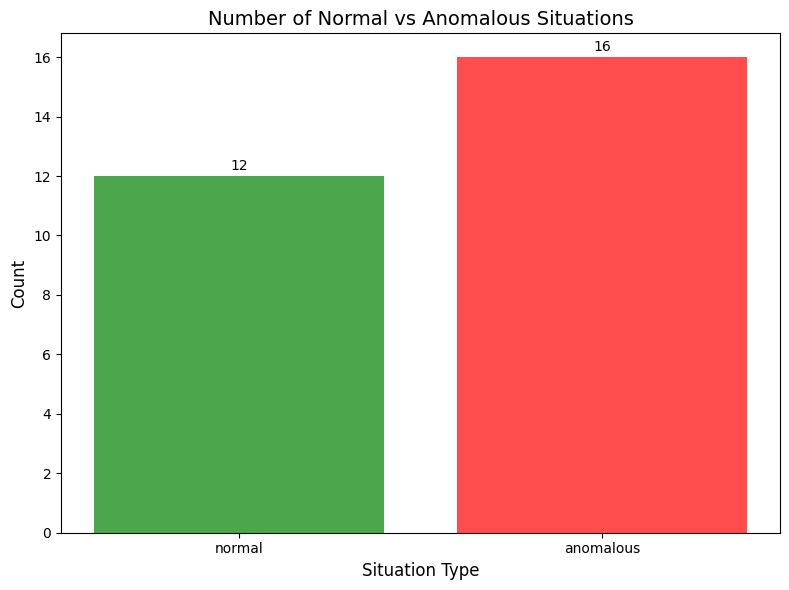

In [114]:
# Plot the distribution of results

# Count the occurrences of "normal" and "anomalous" results
situation_counts = {"normal": 0, "anomalous": 0}
for entry in dataset:
    result = entry.get("result", "unknown").lower()
    if result in situation_counts:
        situation_counts[result] += 1

# Extract keys and values for the bar chart
labels = list(situation_counts.keys())
counts = list(situation_counts.values())

# Plot the bar chart
plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['green', 'red'], alpha=0.7)

# Add labels and title
plt.xlabel("Situation Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Number of Normal vs Anomalous Situations", fontsize=14)

# Annotate bars with counts
for i, count in enumerate(counts):
    plt.text(i, count + 0.2, str(count), ha='center', fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()


In [115]:
# So what are the anomalous items??

for datapoint in dataset:
    try:
        result = datapoint["result"]
        if result == "anomalous":
            print(datapoint['input'])
    except ValueError as e:
        pass

[{'timestamp': 1738065600, 'room': 'pillbox', 'nodeId': 1, 'onOff': True}, {'timestamp': 1738065660, 'room': 'bedroom', 'nodeId': 2, 'onOff': True}, {'timestamp': 1738065900, 'room': 'bathroom', 'nodeId': 2, 'onOff': True}, {'timestamp': 1738066200, 'room': 'bathroom', 'nodeId': 3, 'humidity': 7500}, {'timestamp': 1738066500, 'room': 'bathroom', 'nodeId': 2, 'onOff': False}, {'timestamp': 1738066800, 'room': 'bathroom', 'nodeId': 3, 'humidity': 7500}, {'timestamp': 1738067100, 'room': 'bathroom', 'nodeId': 3, 'humidity': 7500}, {'timestamp': 1738067400, 'room': 'bathroom', 'nodeId': 3, 'humidity': 7500}, {'timestamp': 1738067700, 'room': 'bathroom', 'nodeId': 3, 'humidity': 7500}, {'timestamp': 1738068000, 'room': 'bathroom', 'nodeId': 3, 'humidity': 7500}, {'timestamp': 1738068300, 'room': 'bathroom', 'nodeId': 3, 'humidity': 7500}, {'timestamp': 1738068600, 'room': 'bathroom', 'nodeId': 3, 'humidity': 7500}, {'timestamp': 1738068900, 'room': 'bathroom', 'nodeId': 3, 'humidity': 7500}

## Now it's time to curate our dataset

We select all items

We will be create Item instances, which truncate the input and reasoning to fit within 180 tokens using the right Tokenizer

And will create a prompt to be used during Training.

Items will be rejected if they don't have sufficient characters.

## But why 180 tokens??

This is an example of a "hyper-parameter". In other words, it's basically trial and error! We want a sufficiently large number of tokens so that we have enough useful information to gauge the price. But we also want to keep the number low so that we can train efficiently. 

I started with a number that seemed reasonable, and experimented with a few variations before settling on 180. If you have time, you should do the same! You might find that you can beat my results by finding a better balance. This kind of trial-and-error might sound a bit unsatisfactory, but it's a crucial part of the data science R&D process.

There's another interesting reason why we might favor a lower number of tokens in the training data. When we eventually get to use our model at inference time, we'll want to provide new products and have it estimate a price. And we'll be using short descriptions of products - like 1-2 sentences. For best performance, we should size our training data to be similar to the inputs we will provide at inference time.



In [116]:
# Create an Item object for each with a result

items = []
for datapoint in dataset:
    try:
        result = datapoint["result"]
        if result == 'normal' or result == 'anomalous':
            item = Item(datapoint, result)
            if item.include:
                items.append(item)
    except ValueError as e:
        pass

print(f"There are {len(items):,} items")

There are 28 items


In [117]:
# Look at the first item

items[1]

<$normal>

In [118]:
# Investigate the prompt that will be used during training - the model learns to complete this

print(items[1].prompt)

How would you classify this sensor data - normal or anomalous?

[{"timestamp": 1737892800, "room": "pillbox", "nodeId": 1, "onOff": true}, {"timestamp": 1737892860, "room": "bedroom", "nodeId": 2, "onOff": true}, {"timestamp": 1737893100, "room": "bathroom", "nodeId": 2, "onOff": true}, {"timestamp": 1737893400, "room": "bathroom", "nodeId": 3, "humidity": 6500}, {"timestamp": 1737893700, "room": "bathroom", "nodeId": 2, "onOff": false}, {"timestamp": 1737894000, "room": "

Result is normal


In [119]:
# Investigate the prompt that will be used during testing - the model has to complete this

print(items[1].test_prompt())

How would you classify this sensor data - normal or anomalous?

[{"timestamp": 1737892800, "room": "pillbox", "nodeId": 1, "onOff": true}, {"timestamp": 1737892860, "room": "bedroom", "nodeId": 2, "onOff": true}, {"timestamp": 1737893100, "room": "bathroom", "nodeId": 2, "onOff": true}, {"timestamp": 1737893400, "room": "bathroom", "nodeId": 3, "humidity": 6500}, {"timestamp": 1737893700, "room": "bathroom", "nodeId": 2, "onOff": false}, {"timestamp": 1737894000, "room": "

Result is 


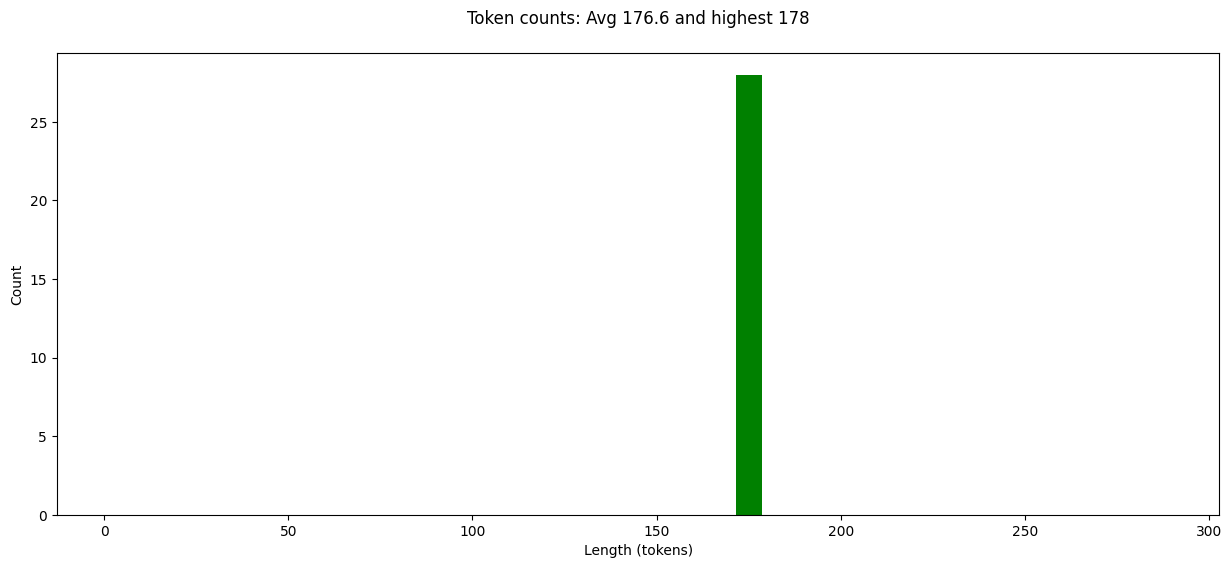

In [120]:
# Plot the distribution of token counts

tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="green", bins=range(0, 300, 10))
plt.show()

## Sidenote

If you like the variety of colors that matplotlib can use in its charts, you should bookmark this:

https://matplotlib.org/stable/gallery/color/named_colors.html

## Todos for you:

- Review the Item class and check you're comfortable with it
- Examine some Item objects, look at the training prompt with `item.prompt` and test prompt with `item.test_prompt()`
- Make some more histograms to better understand the data



# Finally
- Its time to break down our data into a training, test and validation dataset.
- Its typical to use 5%-10% of your data for testing purposes, but actually we have far more than we need at this point. Well take 400,000 points for training, and we'll reserve 2,000 for testing, although we won't use all of them.


Craft a dataset which is more balanced in terms of results. Try to balance out the categories - fewer anomalous items.

In [121]:
# Create a dict with a key of each result from normal to anomalous
# And in the result, put a list of items with that result (

slots = defaultdict(list)
for item in items:
    slots[item.result].append(item)

In [122]:
slots['normal']

[<$normal>,
 <$normal>,
 <$normal>,
 <$normal>,
 <$normal>,
 <$normal>,
 <$normal>,
 <$normal>,
 <$normal>,
 <$normal>,
 <$normal>,
 <$normal>]

In [123]:
# Create a dataset called "sample" which tries to more evenly take from the range of results
# And gives more weight to items from categories other than Anomalous
# Set random seed for reproducibility

# Note: we are duplicating data here to increase our training and test data.

np.random.seed(42)
random.seed(42)
size=50
sample = []
for i in ['normal', 'anomalous']:
    slot = slots[i]
    weights = np.array([1 if item.result=='Normal' else 2 for item in slot])
    weights = weights / np.sum(weights)
    selected_indices = np.random.choice(len(slot), size=size, replace=True, p=weights)
    selected = [slot[i] for i in selected_indices]
    sample.extend(selected)

print(f"There are {len(sample):,} items in the sample")

There are 100 items in the sample


In [124]:
random.seed(42)
random.shuffle(sample)
train = sample[:80]
test = sample[80:100]
print(f"Divided into a training set of {len(train):,} items and test set of {len(test):,} items")

Divided into a training set of 80 items and test set of 20 items


In [125]:
print(train)

[<$normal>, <$normal>, <$anomalous>, <$normal>, <$anomalous>, <$anomalous>, <$normal>, <$anomalous>, <$normal>, <$anomalous>, <$anomalous>, <$normal>, <$anomalous>, <$anomalous>, <$anomalous>, <$normal>, <$normal>, <$anomalous>, <$anomalous>, <$normal>, <$normal>, <$normal>, <$normal>, <$anomalous>, <$anomalous>, <$normal>, <$anomalous>, <$normal>, <$anomalous>, <$normal>, <$normal>, <$normal>, <$anomalous>, <$anomalous>, <$anomalous>, <$normal>, <$anomalous>, <$anomalous>, <$anomalous>, <$normal>, <$normal>, <$normal>, <$normal>, <$normal>, <$normal>, <$anomalous>, <$anomalous>, <$anomalous>, <$normal>, <$normal>, <$anomalous>, <$normal>, <$normal>, <$anomalous>, <$normal>, <$normal>, <$anomalous>, <$anomalous>, <$normal>, <$anomalous>, <$normal>, <$normal>, <$normal>, <$anomalous>, <$anomalous>, <$normal>, <$anomalous>, <$normal>, <$anomalous>, <$normal>, <$normal>, <$anomalous>, <$anomalous>, <$anomalous>, <$anomalous>, <$anomalous>, <$normal>, <$anomalous>, <$anomalous>, <$anomalou

In [126]:
# One more thing!
# Let's pickle the training and test dataset so we don't have to execute all this code next time!

with open('train.pkl', 'wb') as file:
    pickle.dump(train, file)

with open('test.pkl', 'wb') as file:
    pickle.dump(test, file)